In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
from ggplot import *
plt.style.use('ggplot') 

# for maps
from mapboxgl.utils import *
from mapboxgl.viz import *
import geojson

/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Load the data

In [2]:
file_path_1 = './data/Police_Department_Crash_Data_-_Historical.csv'
file_path_2 = './data/Police_Department_Crash_Data_-_Updated.csv'

data_1 = pd.read_csv(file_path_1)
data_2 = pd.read_csv(file_path_2)

/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (68,115) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data wrangling

In [3]:
# Fix column names to match across datasets
data_1 = data_1.rename(columns={"Day Of Week": "Day of Week", "Steet Name": "Street Name"})

In [4]:
# Extract coordinates for each crash location
# If coordinates don't exist drop row
data_1 = data_1.dropna(subset=['Latitude', 'Longitude'])
data_1 = data_1.drop(columns=['Coordinates'])

In [5]:
# Drop rows without location
data_2 = data_2.dropna(subset=['Location'])
# Drop rows without coordinates (these just use city center)
data_2 = data_2.drop(data_2[data_2['Location'].apply(lambda x: len(x.split('\n')) != 3)].index)
# Create Coordinate column
data_2['Coordinates'] = data_2['Location'].apply(lambda x: x.split('\n')[2])
# Create Latitude and Longitude columns
data_2['Latitude'] = data_2['Coordinates'].apply(lambda x: float(x.split(',')[0].replace('(', '')))
data_2['Longitude'] = data_2['Coordinates'].apply(lambda x: float(x.split(',')[1].replace(')', '')))
# Drop the no longer needed Coordinates column
data_2 = data_2.drop(columns=['Coordinates'])

In [6]:
# Combine datasets now
data = pd.concat([data_1, data_2])

In [7]:
# Filter for only the interesting and filled in data
data = data[['Date Time', 'Day of Week', 'Object 1', 'Object 2', 'Street Number', 'Street Name', 'Cross Street', 'Location', 'Latitude', 'Longitude', 'Manner of Collision', 'May Involve Pedestrian', 'May involve cyclist', 'Near Street', 'Nearest Intersection Distance']]

In [8]:
# Convert data types for easier analysis
data['Date Time'] = data['Date Time'].apply(lambda x: pd.to_datetime(x))
# Create new columns for analysis
data['Coordinates'] = data.apply(lambda x: str(x["Latitude"]) + ',' + str(x["Longitude"]), axis=1)
data['Hour of Day'] = data['Date Time'].apply(lambda x: x.hour)
data['Year'] = data['Date Time'].apply(lambda x: x.year)
data['Objects Involved'] = data.apply(lambda x: str(x["Object 1"]) + '-' + str(x["Object 2"]), axis=1)
data['Bicycle Involved'] = data.apply(lambda x: (x['Object 1'] == 'Bicycle') | (x['Object 2'] == 'Bicycle') | (x['May involve cyclist'] == True), axis=1)
data['Pedestrian Involved'] = data.apply(lambda x: (x['Object 1'] == 'Pedestrian') | (x['Object 2'] == 'Pedestrian') | (x['May Involve Pedestrian'] == True), axis=1)
data['No Bike or Pedestrian Involved'] = data.apply(lambda x: (x['Bicycle Involved'] == False) and (x['Pedestrian Involved'] == False), axis=1)
data['Date'] = data['Date Time'].apply(lambda x: pd.to_datetime(x.date()))

## Analysis

### Interesting questions
* Where did the accidents take place?
* Who were they between?
* What time of day/day of week?
* Did they increase/decrease over time? Per location?
* Look at variables that could have made a difference (junction type, surface condition, street vs intersection, weather condition)

### Where do accidents take place?

In [9]:
location_groups = data.groupby(['Latitude', 'Longitude'])
locations_df = location_groups.size().to_frame(name='# of accidents').reset_index()

In [10]:
locations_df.sort_values(by=['# of accidents'], ascending=False).head()

,Latitude,Longitude,# of accidents
1682,42.366794,-71.106006,1407
6301,42.393435,-71.125779,64
353,42.360154,-71.094882,50
689,42.362626,-71.099028,41
5098,42.381983,-71.126634,35


In [13]:
# Drop the coordinates of City Hall
# Must be default if nothing was originally reported
locations_cleaned = locations_df.drop([1682])

In [14]:
locations_cleaned.sort_values(by=['# of accidents'], ascending=False).head()

,Latitude,Longitude,# of accidents
6301,42.393435,-71.125779,64
353,42.360154,-71.094882,50
689,42.362626,-71.099028,41
5098,42.381983,-71.126634,35
3862,42.373761,-71.118858,33


### Who are they between?

In [15]:
object_groups = data.groupby(['Objects Involved'])
objects_df = object_groups.size().to_frame(name='# of accidents').reset_index()

In [16]:
objects_df.sort_values(by=['# of accidents'], ascending=False).head(15)

,Objects Involved,# of accidents
0,Auto-Auto,3008
8,Auto-Parked Vehicle,1838
98,PASSENGER CAR-nan,1811
89,PASSENGER CAR-PASSENGER CAR,1428
1,Auto-Bicycle,779
51,"LIGHT TRUCK(VAN, MINI VAN, PICK-UP, SPORT UTIL...",707
86,"PASSENGER CAR-LIGHT TRUCK(VAN, MINI VAN, PICK-...",550
45,"LIGHT TRUCK(VAN, MINI VAN, PICK-UP, SPORT UTIL...",507
9,Auto-Pedestrian,438
42,"LIGHT TRUCK(VAN, MINI VAN, PICK-UP, SPORT UTIL...",365


#### Bicycles

In [17]:
bicycle_groups = data[(data['Bicycle Involved'] == True)].groupby(['Objects Involved'])
bicycles_df = bicycle_groups.size().to_frame(name='# of accidents').reset_index()

In [19]:
bicycles_df.sort_values(by=['# of accidents'], ascending=False).head(15)

,Objects Involved,# of accidents
0,Auto-Bicycle,779
23,PASSENGER CAR-nan,313
14,"LIGHT TRUCK(VAN, MINI VAN, PICK-UP, SPORT UTIL...",155
29,Taxi-Bicycle,43
34,nan-nan,30
30,Truck-Bicycle,14
6,Bicycle-Parked Vehicle,10
25,"SINGLE UNIT TRUCK (2 AXLES, 6 TIRES)-nan",7
10,Bus (Other)-Bicycle,6
3,Bicycle-Auto,6


#### Pedestrians

In [20]:
pedestrian_groups = data[(data['Pedestrian Involved'] == True)].groupby(['Objects Involved'])
pedestrians_df = pedestrian_groups.size().to_frame(name='# of accidents').reset_index()

In [21]:
pedestrians_df.sort_values(by=['# of accidents'], ascending=False).head(15)

,Objects Involved,# of accidents
0,Auto-Pedestrian,438
14,PASSENGER CAR-nan,196
6,"LIGHT TRUCK(VAN, MINI VAN, PICK-UP, SPORT UTIL...",89
24,nan-nan,18
21,Taxi-Pedestrian,15
22,Truck-Pedestrian,7
1,Bicycle-Pedestrian,5
2,Bus (Other)-Pedestrian,4
9,OTHER-nan,4
13,PASSENGER CAR-PASSENGER CAR,4


### When do accidents take place?

In [22]:
day_of_week_groups = data.groupby(['Day of Week'])
day_of_week_df = day_of_week_groups.size().to_frame(name='# of accidents').reset_index()

In [25]:
day_of_week_df.sort_values(by=['# of accidents'], ascending=False).head(7)

,Day of Week,# of accidents
4,Thursday,2172
0,Friday,2152
5,Tuesday,2120
7,Wednesday,2114
1,Monday,1935
2,Saturday,1589
3,Sunday,1338


In [26]:
time_of_day_groups = data.groupby(['Hour of Day'])
time_of_day_df = time_of_day_groups.size().to_frame(name='# of accidents').reset_index()

In [27]:
time_of_day_df.sort_values(by=['# of accidents'], ascending=False).head(24)

,Hour of Day,# of accidents
9,9,959
18,18,954
12,12,939
14,14,926
17,17,926
15,15,867
8,8,850
11,11,843
13,13,827
16,16,766


### How are they doing over time?

In [28]:
# Annual Datasets
data_2010 = data[(data['Year'] == 2010)]
data_2011 = data[(data['Year'] == 2011)]
data_2012 = data[(data['Year'] == 2012)]
data_2013 = data[(data['Year'] == 2013)]
data_2014 = data[(data['Year'] == 2014)]
data_2015 = data[(data['Year'] == 2015)]
data_2016 = data[(data['Year'] == 2016)]
data_2017 = data[(data['Year'] == 2017)]

In [29]:
accidents_by_day = data.groupby('Date').size()

In [30]:
accidents_by_day_df = accidents_by_day.to_frame(name='# of accidents').reset_index()

In [31]:
accidents_by_month = accidents_by_day.resample('M').sum()

In [32]:
accidents_by_year = accidents_by_day.resample('Y').sum()

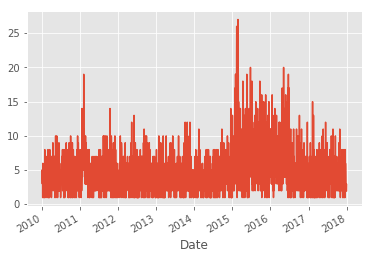

In [33]:
accidents_by_day.plot()

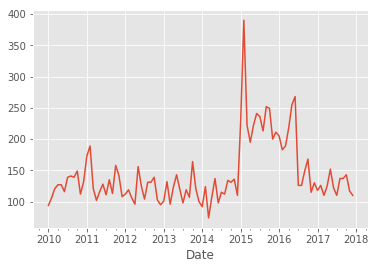

In [34]:
accidents_by_month.plot()

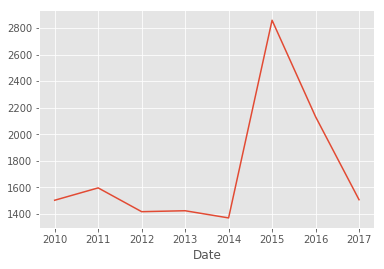

In [35]:
accidents_by_year.plot()

#### Bicycle Accidents over time

In [36]:
bicycle_accidents_by_day = data[(data['Bicycle Involved'] == True)].groupby('Date').size()

In [37]:
bicycle_accidents_by_month = bicycle_accidents_by_day.resample('M').sum()

In [38]:
bicycle_accidents_by_year = bicycle_accidents_by_day.resample('Y').sum()

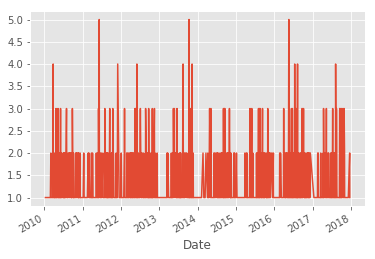

In [39]:
bicycle_accidents_by_day.plot()

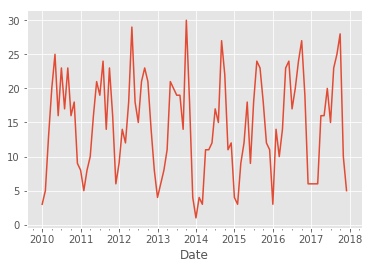

In [40]:
bicycle_accidents_by_month.plot()

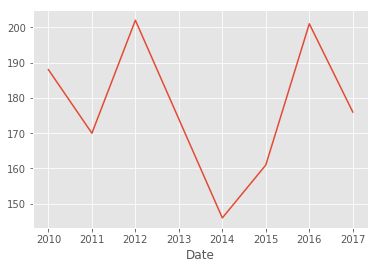

In [41]:
bicycle_accidents_by_year.plot()

#### Pedestrian Accidents over time

In [42]:
pedestrian_accidents_by_day = data[(data['Pedestrian Involved'] == True)].groupby('Date').size()

In [43]:
pedestrian_accidents_by_month = pedestrian_accidents_by_day.resample('M').sum()

In [44]:
pedestrian_accidents_by_year = pedestrian_accidents_by_day.resample('Y').sum()

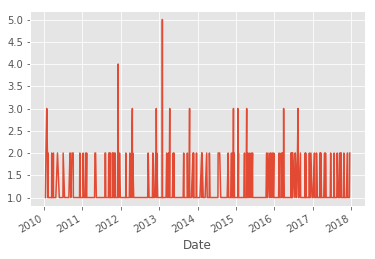

In [45]:
pedestrian_accidents_by_day.plot()

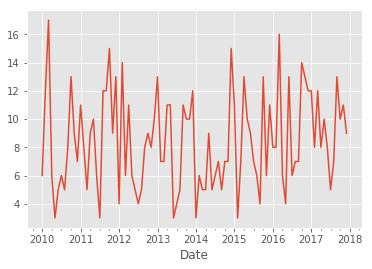

In [46]:
pedestrian_accidents_by_month.plot()

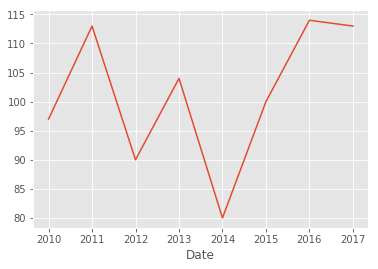

In [47]:
pedestrian_accidents_by_year.plot()

## Map Data

In [54]:
# all accidents
df_to_geojson(data, filename='output/all_accidents.geojson',
              properties=['Object 1', 'Object 2', 'Day of Week', 'Year', 'Bicycle Involved', 'Pedestrian Involved', 'No Bike or Pedestrian Involved'],
              lat='Latitude', lon='Longitude', precision=7)

{'feature_count': 13807,
 'filename': 'output/all_accidents.geojson',
 'type': 'file'}

## Some things noticed:
* Big drop in bicycle and pedestrian accidents in 2014, less accidents? or worse reporting?
* Big spike in all accidents in 2015, reporting change? or actual increase?
* Large number of reported accident coordinates are City Hall, likely what's used when it's not reported or not accurately reported